# Twitter - Real-Time Streaming

**Problem Statement:**
- To save the real-time tweets to a file
- To query the data

**Importing all necessary libraries**

In [1]:
%matplotlib inline
import tweepy
import pandas as pd
import json
import numbers
import re
import os.path
import datetime
import numpy as np

pd.options.display.max_colwidth = 400
pd.options.display.max_rows = 25
pd.options.display.max_columns = None

In [2]:
# To load credentials

def load_credentials():
    consumer_key, consumer_key_secret, access_token, access_token_secret = (None,)*4
    if not os.path.isfile('credentials.ini'): 
        return consumer_key, consumer_key_secret, access_token, access_token_secret
    lines = [line.rstrip('\n') for line in open('credentials.ini')]
    chars_to_strip = " \'\""
    for line in lines:
        if "consumer_key" in line and 'fill_in' not in line:
            consumer_key = re.findall(r'[\"\']([^\"\']*)[\"\']', line)[0]
        if "consumer_secret" in line and 'fill_in' not in line:
            consumer_key_secret = re.findall(r'[\"\']([^\"\']*)[\"\']', line)[0]
        if "access_token" in line and 'fill_in' not in line:
            access_token = re.findall(r'[\"\']([^\"\']*)[\"\']', line)[0]
        if "access_secret" in line and 'fill_in' not in line:
            access_token_secret = re.findall(r'[\"\']([^\"\']*)[\"\']', line)[0]
    return consumer_key, consumer_key_secret, access_token, access_token_secret

In [3]:
consumer_key, consumer_key_secret, access_token, access_token_secret = load_credentials()
if not all([consumer_key, consumer_key_secret, access_token, access_token_secret]):
    consumer_key = 'my_consumer_key'
    consumer_key_secret = 'my_consumer_key_secret'
    access_token = 'my_access_token'
    access_token_secret = 'my_access_token_secret'
auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [4]:
# To test the credentials, this pulls 20 tweets from my Twitter timeline

tweets_raw_data = []
public_tweets = api.home_timeline()
for tweet in public_tweets:
    print tweet.text
    tweets_raw_data.append(tweet)

Maldives President Solih receives a ceremonial welcome in New Delhi
https://t.co/hJiE8O5Owl
Jennifer Egan’s “Manhattan Beach” was the favorite book of New York City library readers during the past year https://t.co/cHofwZGKb7
#SajjanConvicted | Congress leaders instigated mobs in 1984: Arun Jaitley hits out at Congress. Tune in to watch it… https://t.co/tEmZYGTTYC
IN PICS | Sakshi Dhoni makes MS Dhoni tie her heels straps at a store and her reason is interesting!
https://t.co/ek8tb7Mh6C
#SajjanConvicted | Sajjan Kumar’s conviction by the Delhi High Court is a delayed vindication of Justice. The Congr… https://t.co/TbnJZNjdHE
Stop Kamal Nath's swearing: Former Punjab CM Parkash Singh Badal after #SajjanConvicted in 1984 anti-Sikh riots case
https://t.co/BpBO5zfuSG
Former Miss Universe Sushmita Sen had this to say to 2018 Pageant winner Catriona Gray 
https://t.co/7bPfZcd3Es
After #SajjanConvicted, politicians demand action against Kamal Nath in 1984 case
https://t.co/p8df336NlQ
#SajjanC

**Building a stream listener**

In [18]:
# Code source: https://github.com/tweepy/tweepy/blob/v3.5.0/docs/streaming_how_to.rst

class MyStreamListener(tweepy.StreamListener):
    
    def __init__(self,limit=20,print_output=True,save_output=True,
                 filename='file.csv',include_rts=True,strict_text_search=True,
                 search_terms=None):
        self.df = pd.DataFrame()
        self.limit = limit
        self.counter = 0
        self.print_output = print_output
        self.header=False
        self.save_output=save_output
        self.filename=filename
        self.include_rts=include_rts
        self.strict_text_search = strict_text_search
        self.search_terms = search_terms
        
    def on_data(self, data):
        d = {}
        decoded = json.loads(data)
        # full list of fields you can collect: https://dev.twitter.com/overview/api/tweets
        tweet_fields_to_collect = ['created_at','id','text','source','favorite_count']
        user_fields_to_collect = ['name','screen_name','location','id_str','statuses_count','followers_count','friends_count','favourites_count','description']
        if self.strict_text_search:
            if not isinstance(self.search_terms, list):
                self.search_terms = re.findall(r"[\w']+", self.search_terms)
            if not any(term.lower() in decoded['text'].lower() for term in self.search_terms):
                print "skipped"
                print decoded['text']
                return True
        for k,v in decoded.iteritems():
            if k in tweet_fields_to_collect:
                if isinstance(v, numbers.Number):
                    v = str(v)
                try:
                    d['tweet_' + k.strip()] = v
                except:
                    print "Failure collecting tweet field", v.encode('ascii', 'ignore')
            if k=='user':
                for user_k,user_v in v.iteritems():
                    if user_k in user_fields_to_collect:
                        if isinstance(user_v, numbers.Number):
                            user_v = str(user_v)
                        try:
                            d[user_k.strip()]=user_v
                        except:
                            print "Failure collecting user field",user_v.encode('ascii', 'ignore')
                            
            if k=='retweeted_status':
                for retweet_k,retweet_v in v.iteritems():
                    if retweet_k in tweet_fields_to_collect:
                        if isinstance(retweet_v, numbers.Number):
                            retweet_v = str(retweet_v)
                        try:
                            d['retweet_'+retweet_k.strip()]=retweet_v
                        except:
                            print "Failure collecting retweet field",user_v.encode('ascii', 'ignore')
        if not self.include_rts:
            if ('retweet_text' in d and len(d['retweet_text'])>0) or d['tweet_text'].startswith('RT @'):
                return True
        tweet_df = pd.DataFrame(d, index=[0])
        frames = [self.df, tweet_df]
        self.df = pd.concat(frames)
        self.counter+=1
        if self.print_output:
            try:
                print(decoded['text'])
            except:
                print("Failure outputting tweet text",decoded['text'].encode('ascii', 'ignore'))
        if self.counter>=self.limit:
            print("finished collecting %s tweets, ending" % self.limit)
            if self.include_rts and 'retweet_text' in self.df.columns:
                self.df = self.df[['tweet_' + x for x in tweet_fields_to_collect] + user_fields_to_collect + ['retweet_' + x for x in tweet_fields_to_collect]]
            else:
                self.df = self.df[['tweet_' + x for x in tweet_fields_to_collect] + user_fields_to_collect]
            
            self.df.rename(columns={'id_str':'user_id'},inplace=True)
            self.df.to_csv(self.filename, index=False, encoding='utf-8')
            return False
        else:
            return True
        
    def on_error(self, status_code):
        if status_code == 420:
            return False
        
    def on_disconnect(self, notice):
        print("disconnecting due to " + str(notice))

**To search for a keyword and read and load respective tweets to a .csv file**

In [7]:
search_query = 'bigdata'
filename = '%s_%s.csv' % (search_query, datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S"))

''' Parameters:
limit=50 indicates the maximum number of tweets this retrieves
strict_text_search=True to search exactly as per the search query keyword
filename=filename to get the filename as mentioned above. serachquery_currentdateTime
search_terms=search_query to search only terms in the search query'''

myStreamListener = MyStreamListener(limit=50,
                                    print_output=False,
                                    filename=filename,
                                    search_terms=search_query,
                                    strict_text_search=True)

myStream = tweepy.Stream(auth, listener=myStreamListener)
myStream.filter(track=[search_query])
bigdata_df = pd.read_csv(filename)

skipped
CRM &amp; Data Analysis Officer - Aquent &amp; Vitamin T ( London, United Kingdom )  - [ ➡ https://t.co/prPzsVGGbn ]… https://t.co/gKMA2FRkc2
skipped
#hong #kong #exchange #‘hesitant’ to #approve #bitmain #ipo, says #source 
#instabtc #instaeth #cryptocurrency #xrp… https://t.co/56LY1Mjo6d


/Users/rashmimahesh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:73: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



skipped
RT @SA_Qlik: IsoMetrix is a SA Qlik OEM Partner, and a leading supplier of integrated software for Governance, Risk, and Compliance. Find o…
skipped
RT @CoinCapsAi: #hong #kong #exchange #‘hesitant’ to #approve #bitmain #ipo, says #source 
#instabtc #instaeth #cryptocurrency #xrp #tradin…
skipped
5 things to know about the future of jobs 
https://t.co/4LhMp2xrCa 

#FutureOfWork AI #IoT #ML #automation… https://t.co/9GkgYjBjpN
skipped
Amusing. But X? No. I still see people casually, and daily, destroying the rainforest on MFDs.
skipped
RT @KirkDBorne: WOW! &gt;&gt; Fantastic Comprehensive Guide for Applying #MachineLearning Techniques in Finance, including evaluation of 156 clas…
skipped
Big Data in Internet of Things (IoT) 2018-2023: Technologies, Companies and Solutions - GlobeNewswire
Read more her… https://t.co/wsJ0hJfBcW
skipped
How Big Data Has Created a Big Crisis in Science - American Council on Science and Health
Read more here:… https://t.co/TYzImQEI6c
skipped
RT @maxv

skipped
RT @BristowColin: How big data has created a big crisis in science - The Conversation - US
Read more here: https://t.co/ghEMej8lIt

#BigDat…
skipped
RT @StarkDigitalBiz: AI and Robotics technologies come in many forms, giving rise to a broad variety of Applications 

#AI #Cognitive #BigD…
skipped
RT @dinosaurier: https://t.co/rWcAHTN2P4 Das "Argumentation-Mining" ist ganz sicher eine "rote Linie" der #ai Entwicklung! Das heißt ja nic…
skipped
RT @BristowColin: Big Data in Internet of Things: IoT Data Management, Analytics and Decision Making (2018-2023) - https://t.co/Q9gDFIALPg…
skipped
RT @BristowColin: How big data has created a big crisis in science - The Conversation - US
Read more here: https://t.co/ghEMej8lIt

#BigDat…
skipped
RT @JessHurwitz: How Smart Are Your Ships? Interview with Derek Novak, SVP Engineering &amp; Technology, American Bureau of Shipping (ABS)

#sh…
skipped
RT @JessHurwitz: How Smart Are Your Ships? Interview with Derek Novak, SVP Engineering &amp; Te

In [9]:
bigdata_df

,tweet_created_at,tweet_id,tweet_text,tweet_source,tweet_favorite_count,tweet_coordinates,tweet_lang,tweet_place,tweet_retweet_count,tweet_retweeted,tweet_truncated,name,screen_name,location,user_id,statuses_count,followers_count,friends_count,favourites_count,description,retweet_created_at,retweet_id,retweet_text,retweet_source,retweet_favorite_count,retweet_coordinates,retweet_lang,retweet_place,retweet_retweet_count,retweet_retweeted,retweet_truncated
0,Mon Dec 17 06:01:02 +0000 2018,1074544983049494529,RT @VladoBotsvadze: Smart solutions for smart cities. #AI #fintech #IoT #robots #datascience #blockchain #bigdata #machinelearning #deeplea…,"<a href=""https://t.yvn.io"" rel=""nofollow"">totem-socket</a>",0,NaN,en,NaN,0,False,False,Grigor Khachatryan,Grigortw,"New York, NY",117490122,101800,3638,245,69662,"Chief Architect at @MapprInfo, #VR/#AR enginner, open source enthusiast. Thoughts on #IoT, #BigData, #DataScience, #AI, #Devops & #Docker.",Tue Jun 19 16:11:27 +0000 2018,1.009106e+18,Smart solutions for smart cities. #AI #fintech #IoT #robots #datascience #blockchain #bigdata #machinelearning… https://t.co/e1d6ldh1B7,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",150.0,NaN,en,NaN,142.0,False,True
1,Mon Dec 17 06:01:14 +0000 2018,1074545031493505024,RT @workinbigdata: Analyst - Analytics and Business Intelligence - Crossmedia - [ 📋 More Info https://t.co/dX8TmUoPPt ] #BigData #DataScie…,"<a href=""http://decotiismauro.ml"" rel=""nofollow"">akdm_DS_bot</a>",0,NaN,en,NaN,0,False,False,AKDM bot!,akdm_bot,United States,919744697551253505,120214,1219,36,14,Test Robot for @kaumaron and @thenewsunspun,Mon Dec 17 02:01:20 +0000 2018,1.074485e+18,Analyst - Analytics and Business Intelligence - Crossmedia - [ 📋 More Info https://t.co/dX8TmUoPPt ] #BigData… https://t.co/ChyJrLs80k,"<a href=""http://www.waseemly.com"" rel=""nofollow"">SocialTweetHP</a>",0.0,NaN,en,NaN,1.0,False,True
2,Mon Dec 17 06:01:15 +0000 2018,1074545038661705729,The latest The Curated Big Data News! https://t.co/EHwk8ARkCZ #bigdata #datascience,"<a href=""https://paper.li"" rel=""nofollow"">Paper.li</a>",0,NaN,en,NaN,0,False,False,siprasad,siprasad,"Gurgaon, India",14138333,46614,1012,684,482,"Technologist - Cloud, & DevOps; Sports Enthusiast,F1,Badminton,Cycling;Gadgets;Tweets are strictly personal; RT's not endorsement",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Mon Dec 17 06:01:17 +0000 2018,1074545043501932544,RT @ahmedjr_16: 51 Best #BusinessIntelligence #Certification for Business Professionals\n\n#SAP #SQLServer #SQL #AI #DataScience #BI #BigData…,"<a href=""https://www.devstache.io"" rel=""nofollow"">devstache</a>",0,NaN,en,NaN,0,False,False,Ross O'Brien,full_stache_dev,"Aberdeen, Scotland",3428432883,43864,701,331,19,🚀 Dad - Dev - Biker - Student - Facial Hair Connoisseur 💪🏻 IG 📸: https://www.instagram.com/full_stache_developer/,Fri Dec 14 20:35:01 +0000 2018,1.073678e+18,51 Best #BusinessIntelligence #Certification for Business Professionals\n\n#SAP #SQLServer #SQL #AI #DataScience #BI… https://t.co/YsBEmPPXnA,"<a href=""http://app.viraltag.com"" rel=""nofollow"">Viraltag</a>",8.0,NaN,en,NaN,9.0,False,True
4,Mon Dec 17 06:01:17 +0000 2018,1074545043438997504,RT @ahmedjr_16: 51 Best #BusinessIntelligence #Certification for Business Professionals\n\n#SAP #SQLServer #SQL #AI #DataScience #BI #BigData…,"<a href=""https://www.devstache.io"" rel=""nofollow"">devstache</a>",0,NaN,en,NaN,0,False,False,Ross O'Brien,full_stache_dev,"Aberdeen, Scotland",3428432883,43864,701,331,19,🚀 Dad - Dev - Biker - Student - Facial Hair Connoisseur 💪🏻 IG 📸: https://www.instagram.com/full_stache_developer/,Fri Dec 14 20:35:01 +0000 2018,1.073678e+18,51 Best #BusinessIntelligence #Certification for Business Professionals\n\n#SAP #SQLServer #SQL #AI #DataScience #BI… https://t.co/YsBEmPPXnA,"<a href=""http://app.viraltag.com"" rel=""nofollow"">Viraltag</a>",8.0,NaN,en,NaN,9.0,False,True
5,Mon Dec 17 06:01:18 +0000 2018,1074545048069525504,RT @Ronald

In [10]:
print(len(bigdata_df))

50


In [14]:
bigdata_df[bigdata_df['tweet_text'].str.contains('bigdata', case=True, regex=True)][['tweet_text']]

,tweet_text
0,RT @VladoBotsvadze: Smart solutions for smart cities. #AI #fintech #IoT #robots #datascience #blockchain #bigdata #machinelearning #deeplea…
1,RT @workinbigdata: Analyst - Analytics and Business Intelligence - Crossmedia - [ 📋 More Info https://t.co/dX8TmUoPPt ] #BigData #DataScie…
2,The latest The Curated Big Data News! https://t.co/EHwk8ARkCZ #bigdata #datascience
10,Learn what the fuss is all about @gfaccord #bigdata &amp; #AI powered #global #business #consulting… https://t.co/ju2OhtkHSK
11,RT @ipfconline1: 9 types of #innovation to drive #businessgrowth ⬇️ | #bigdata #contentmarketing #growthhacking via @blogalarm https://t.co…
13,Gurus of BI weekly is out! https://t.co/wDaV0FaGSe Guru stories via @timorainio @4productivity @Journotopia #bigdata #analytics
15,The Open Data Daily https://t.co/lwYkAfF8Jh #OpenData #bigdata https://t.co/Fp0HhMyD4i
17,RT @wiomax: Exploring the Increased Significance of Third Party Data Within Big Data https://t.co/s1z4VJ3Au6 #bigdata #data #DataScience #D…
18,"The Machine Learning Race Is Really a Data Race, vía @mitsmr https://t.co/ZlTVt8EYdl #bigdata… https://t.co/d0ggrCI0pf"
29,The Brussels Data Science Community is out! https://t.co/AbtNEF9FYR #datascience #bigdata


In [15]:
'''To print the value of the below fields 'tweet_fields_to_collect' and 'user_fields_to_collect' in the tweets'''

bigdata_df.query

<bound method DataFrame.query of                   tweet_created_at             tweet_id  \
0   Mon Dec 17 06:01:02 +0000 2018  1074544983049494529   
1   Mon Dec 17 06:01:14 +0000 2018  1074545031493505024   
2   Mon Dec 17 06:01:15 +0000 2018  1074545038661705729   
3   Mon Dec 17 06:01:17 +0000 2018  1074545043501932544   
4   Mon Dec 17 06:01:17 +0000 2018  1074545043438997504   
5   Mon Dec 17 06:01:18 +0000 2018  1074545048069525504   
6   Mon Dec 17 06:01:18 +0000 2018  1074545048547680256   
7   Mon Dec 17 06:01:25 +0000 2018  1074545078239199232   
8   Mon Dec 17 06:01:27 +0000 2018  1074545085511942144   
9   Mon Dec 17 06:01:29 +0000 2018  1074545095918141441   
10  Mon Dec 17 06:01:39 +0000 2018  1074545139106963456   
11  Mon Dec 17 06:02:11 +0000 2018  1074545270514429952   
..                             ...                  ...   
38  Mon Dec 17 06:12:40 +0000 2018  1074547908714917888   
39  Mon Dec 17 06:12:50 +0000 2018  1074547950481739777   
40  Mon Dec 17 06:13:14

In [19]:
# To display Regression tables and basic charting on users who have less than 500 followers.

import statsmodels.formula.api as sm
import seaborn as sns
result = sm.ols(formula="statuses_count ~ followers_count", data=bigdata_df.query("followers_count<500")).fit()
result.summary()

/Users/rashmimahesh/anaconda2/lib/python2.7/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         statuses_count   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     2.474
Date:                Mon, 17 Dec 2018   Prob (F-statistic):              0.214
Time:                        01:40:52   Log-Likelihood:                -57.811
No. Observations:                   5   AIC:                             119.6
Df Residuals:                       3   BIC:                             118.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        6.253e+04   2.75e+04      2.277      0.107   -2.49e+04     1.5e+05
followers_count  -146.1841     92.930     -1.573      0.214    -441.930     149.562
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.202
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.339
Skew:                           0.142   Prob(JB):                        0.844
Kurtosis:                       1.757   Cond. No.                         553.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

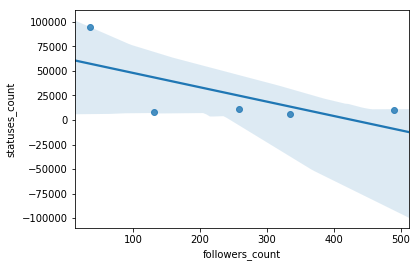

In [23]:
ax = sns.regplot(x="followers_count", y="statuses_count", data=bigdata_df.query('followers_count<500'))

Save the .csv file as .txt and create a data frame to read and load in all the tweets.

In [45]:
tweets_data_path = './bigdata_2018-12-17_01.00.52.txt'

tweets_data = []
tweets_file = open(tweets_data_path, "r")
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue

In [46]:
# To print the length
print len(tweets_data)

1094


In [47]:
mytweets = pd.DataFrame()

In [48]:
mytweets['country'] = map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, tweets_data)

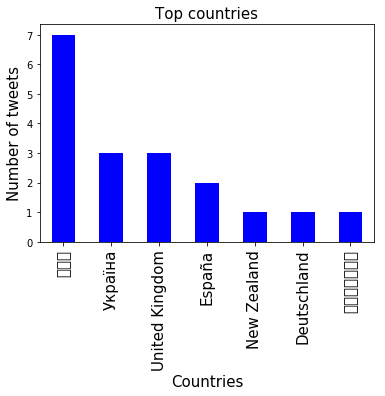

In [50]:
import matplotlib.pyplot as plt

tweets_by_country = mytweets['country'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top countries', fontsize=15)
tweets_by_country[:10].plot(ax=ax, kind='bar', color='blue')

**References:**

- Code from https://github.com/jasonqng/twitter-streaming-python